In [1]:
import sys
sys.path.append("../")

In [27]:
import numpy as np
import pandas as pd

import scipy
from scipy import special

import delay.calculator as calc
import delay.model as model
from delay.delay import *

import matplotlib.pyplot as plt

In [52]:
from importlib import reload
reload(model);

In [16]:
def fA(x, d):
    return N/2 if x <= d else 0

def fB(x, d):
    return N/2 if -d <= x else 0

wentRight = np.zeros(N+1, dtype=int)
wentLeft = np.zeros(N+1, dtype=int)

def simulate():
    def nextElem(func):
        term = -N/2 if func == max else N/2
        rc = calculateValue(previousA, previousB)
        value = -rc if func == max else rc
        return func(x[current] + value, term)
    
    current = len(x)-1
    for _ in range(0, duration):
        previousA, previousB = fA(x[current - tauA], d), fB(x[current - tauB], d)
            
        prob = calculateProbability(previousA - previousB)
        r = random.random()
        if r <= prob:
            i: int = (int)(x[current] + N/2)
            wentRight[i] += 1
            nextElement = nextElem(min) # +1
        else:
            i: int = (int)(x[current] + N/2)
            wentLeft[i] += 1
            nextElement = nextElem(max) # -1
                
        x.append(nextElement)
        current += 1

/home/kamil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


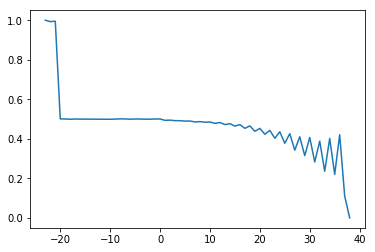

In [18]:
N = 100
tauA = 20
tauB = 0
x = [0] * 20 + [1] 
duration = 10000000 # 10^7
conv = N
d = 20

calculateProbability = calc.linear(N, 0.99)

simulate()
            
s = np.sum([wentLeft, wentRight], axis=0)
rp = np.divide(wentRight, s)
model.plot(rp)

df = pd.DataFrame(data = model.domainDFDict(rp))
df.to_csv('simulation-right-probabilities.csv', index=False)

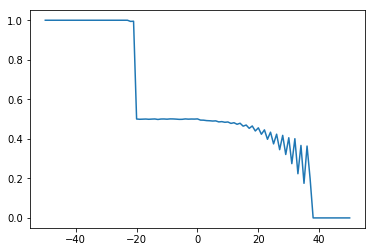

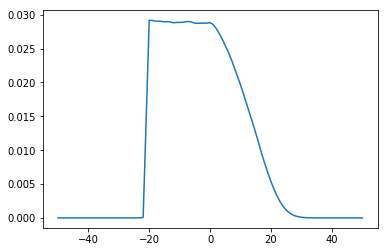

In [64]:
model.plot(rp)
model.makeNonDeterministic(rp)
model.plot(model.probabilities2Stationary(rp))

0.11968199519192305
0.11553468657375526
0.11252438181835887
0.11078474911315106
0.11046109444352228
0.11171128779957652
0.11470676064097322
0.11963358003151484
0.12669360526441192
0.1361057332393979


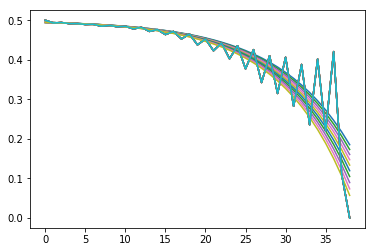

In [40]:
def modelFun(i, x): 
    return 0.5-0.005 * math.exp(0.104*x + 0.001*i*x)

mVec = np.vectorize(modelFun)

for i in range(10):
    experiment = rp[50:89]
    mVal = mVec(i, range(0, 39))
    plt.plot(mVal)
    plt.plot(experiment)
    assert len(experiment) == len(mVal)
    temp = np.subtract(experiment, mVal)
    rmsd = sum(np.multiply(temp, temp))
    print(rmsd)

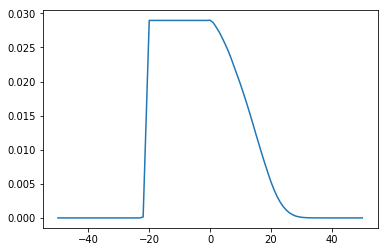

-3.101567774054301


In [70]:
rp = prepareDistribution(experiment)
st = model.probabilities2Stationary(rp)
model.plot(st)
print(model.expectedValue(st))

In [42]:
ev = 0.0
for i in range(41):
    ev += modelFun(5, i)
ev

16.10565131979322

In [45]:
fragm = []
for i in range(41):
    fragm.append(modelFun(5, i))

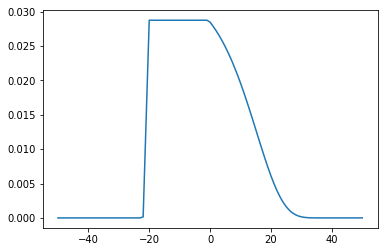

-2.8818254673091253


In [54]:
def prepareDistribution(fragment, d = 20, N=100, epsilon=0.01):
    rp = []
    for i in range(int(-N/2), int(N/2+1)):
        if i < -d:
            rp.append(1-epsilon)
        elif i < 0:
            rp.append(0.5)
        elif i < 2*d:
            rp.append(fragment[i])
        else:
            rp.append(epsilon)
    return rp
        
rp = prepareDistribution(fragm)
st = model.probabilities2Stationary(rp)
model.plot(st)
print(model.expectedValue(st))

Simulation:

**-3.05**

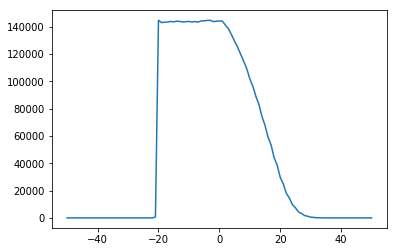

In [40]:
model.plot(wentLeft)

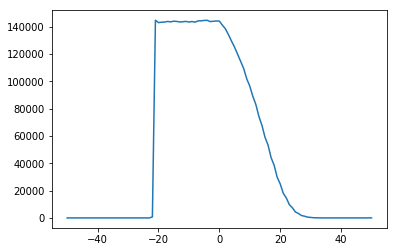

In [41]:
model.plot(wentRight)

In [47]:
data = {
    'x': model.domain(N),
    'left': wentLeft,
    'right': wentRight,
    'divide': rp
}
df = pd.DataFrame(data = data)
df.to_csv('../right probabilities.csv', index=False)

In [1]:
tau=20
d=20
r=10
f = r if r > 0 else -r

k = (tau-f)/2 # >=0
left = min(x, x+r) #left <= right
right = max(x, x+r)
leftMost = left-k #leftMost < rightMost
rightMost = right+k
leftMost = int(max(leftMost, -N/2))
rightMost = int(min(rightMost, N/2))



NameError: name 'x' is not defined

In [36]:
def sample(left, right, k, rp, index, verbose=True):
    goLeft, goRight = np.random.randint(left, right+1, size=(2, k))
    goRight = np.subtract(goRight, 1)
    if verbose: 
        print(goLeft, goRight)
    leftProduct, rightProduct = 1.0, 1.0
    for i in range(k):
        leftProduct *= (1-rp[index(goLeft[i])])
        rightProduct *= rp[index(goRight[i])]
    if verbose:
        print(leftProduct)
        print(rightProduct)
    return leftProduct, rightProduct

def sampleTimes(number, sampleDict):
    lArray, rArray = [], []
    for i in range(number):
        l, r = \
            sample(
                sampleDict['left'],
                sampleDict['right'],
                sampleDict['k'],
                sampleDict['rp'],
                sampleDict['index'],
                verbose=False
            )
        lArray.append(l)
        rArray.append(r)
    return np.mean(lArray), np.mean(rArray)
    
    
sample(51, 59, 3, [0.49, 0.5, 0.47, 0.5, 0.43, 0.49, 0.5, 0.5, 0.37, 0.48], lambda x: x-50)
sampleTimes(100, {'left': 50, 'right': 59, 'k': 3, 'rp': [0.49, 0.5, 0.47, 0.5, 0.43, 0.49, 0.5, 0.5, 0.37, 0.48], 'index': lambda x: x-50})

[53 59 51] [52 53 57]
0.13
0.1175


(0.14521008000000002, 0.10548012999999998)

In [4]:
l = [1, 2, 3]
np.subtract(l, 1)

array([0, 1, 2])

In [14]:
df = pd.DataFrame(data = model.domainDFDict(l))
df.to_csv(index=False)

'x,values\n-1,1\n0,2\n1,3\n'

In [38]:
np.multiply((2, 10), sample(51, 59, 3, [0.49, 0.5, 0.47, 0.5, 0.43, 0.49, 0.5, 0.5, 0.37, 0.48], lambda x: x-50))

[59 52 58] [50 52 57]
0.173628
0.11514999999999999


array([0.347256, 1.1515  ])

[-60. -40. -20.   0.  20.  40.  60.]
[-50. -40. -20.   0.  20.  40.  50.]


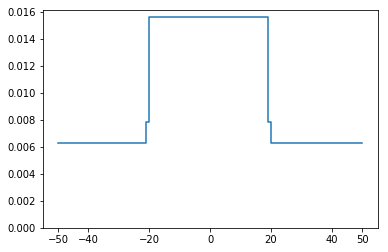

In [89]:
st = model.initialStationaryProbabilities(N=100, epsilon=0.01, d=20)
plt.plot(model.domain(100), st, ls='steps');
_, top = plt.ylim()
plt.ylim(0.0, top)
locs, _ = plt.xticks()
print(locs)
locs[0] = -50
locs[-1] = 50
print(locs)
plt.xticks(locs);